<a href="https://colab.research.google.com/github/jhou27/MachineLearning_with_Python/blob/main/Binary_classification_Neural_network_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import itertools
import seaborn as sns
from sklearn.datasets import make_circles
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

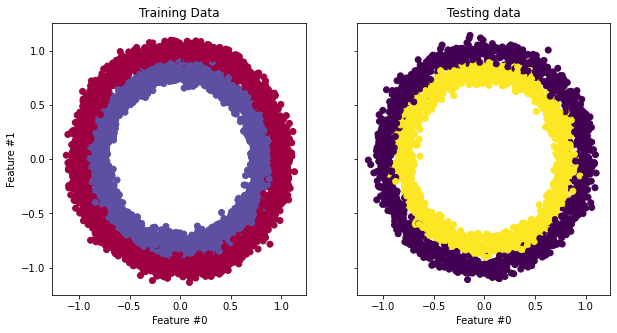

In [5]:
#generate non-linearly related data for classification
X, y = make_circles(n_samples = 10000, noise = 0.05, random_state = 26)

#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#visualize the train and test data
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature #0")
train_ax.set_ylabel("Feature #1")
test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
test_ax.set_title("Testing data")
plt.show()

In [8]:
#a single input data x will have 3 elements (x1,x2)
n_input = 2

#we will use 10 nodes for the hidden layer
n_hidden = 10

#a single output y will have only 1 element: the proability of positvie class
n_out = 1

#we will train 64 sets of (x,y) data at a time, this is called the batch size
batch_size = 64

#the step size for the gradient descent method is 0.05, this is also known as the learning rate
learning_rate = 0.05

In [11]:
#store the training and test data as tensors 
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
    
#load the training and test data as batches
batch_size = 64
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

#check that each batch has the correct dimensions
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


In [12]:
#layer 1
L_1 = nn.Linear(in_features=n_input, out_features=n_hidden, bias=True)

#layer 2
L_2 = nn.Linear(in_features=n_hidden, out_features=n_out, bias=True)

#construct the network
model = nn.Sequential(L_1,
                      nn.ReLU(),
                      L_2,
                      nn.Sigmoid())

print(model)

#choose the Binary Cross Entropy as our loss function
loss_function = nn.BCELoss()

#choose the stochastic gradient descent method as our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
)


In [13]:
losses = []
n_epochs = 200

for i in range(n_epochs+1):
    for X, y in train_dataloader:
        y_hat = model(X)                                    #compute the output with forward propagation
        loss = loss_function(y_hat, y.unsqueeze(-1))        #compute the loss function
        losses.append(loss.item()) 
        model.zero_grad()                                   #set the gradients to zero
        loss.backward()                                     #backward propagation
        optimizer.step()                                    #gradient descent
    if i % 50 == 0:
        print(f'{i} iterations completed, the current loss is: {loss}')

0 iterations completed, the current loss is: 0.6930999755859375
50 iterations completed, the current loss is: 0.26311516761779785
100 iterations completed, the current loss is: 0.16638974845409393
150 iterations completed, the current loss is: 0.07204451411962509
200 iterations completed, the current loss is: 0.06909125298261642


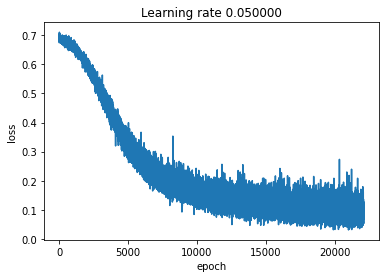

In [14]:
#visualize the minimization process of the loss function 
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [15]:
#make predictions
y_pred, y_test = [],[]
total, correct = 0, 0

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs<0.5, 0, 1)            #classify the output as 1 only when the probability is above 0.5
        predicted = list(itertools.chain(*predicted))
        y_pred += list(predicted)
        y_test += list(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      1502
         1.0       0.96      0.97      0.97      1498

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



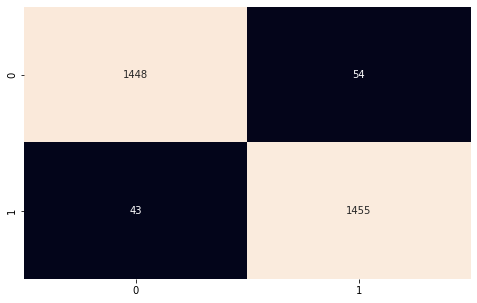

In [16]:
print(classification_report(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred)
plt.subplots(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")
plt.show()